Time series forecasting using amazon stock prices, and LSTM, with PyTorch.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

In [ ]:
data = pd.read_csv('AMZN.csv')

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [ ]:
data.shape

(6516, 7)

In [ ]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-7-1a72a8b5b870>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


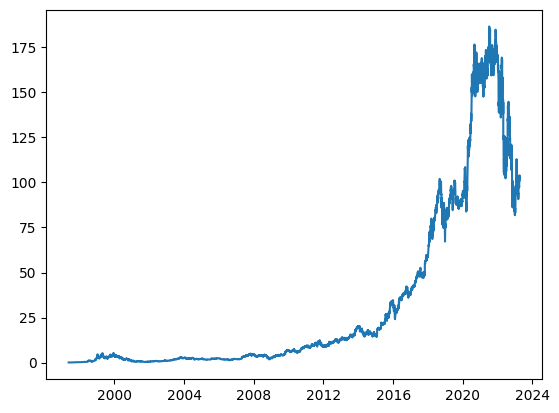

In [ ]:
plt.plot(data['Date'], data['Close'])

In [ ]:
#prepare dataset to train LSTM model
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df.set_index('Date',inplace=True)
  for i in range(n_steps, 0, -1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)
  df.dropna(inplace=True)
  return df

In [ ]:
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,,,
1997-05-27,0.079167,0.097917,0.086458,0.085417,0.081771,0.071354,0.069792,0.075000
1997-05-28,0.076563,0.086458,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167
1997-05-29,0.075260,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563
1997-05-30,0.075000,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260
1997-06-02,0.075521,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260,0.075000
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.610001,98.699997,98.709999,98.129997,98.040001,97.239998,100.250000
2023-03-31,103.290001,98.699997,98.709999,98.129997,98.040001,97.239998,100.250000,102.000000
2023-04-03,102.410004,98.709999,98.129997,98.040001,97.239998,100.250000,102.000000,103.290001


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 9.79170000e-02, 8.64580000e-02, ...,
        7.13540000e-02, 6.97920000e-02, 7.50000000e-02],
       [7.65630000e-02, 8.64580000e-02, 8.54170000e-02, ...,
        6.97920000e-02, 7.50000000e-02, 7.91670000e-02],
       [7.52600000e-02, 8.54170000e-02, 8.17710000e-02, ...,
        7.50000000e-02, 7.91670000e-02, 7.65630000e-02],
       ...,
       [1.02410004e+02, 9.87099990e+01, 9.81299970e+01, ...,
        1.00250000e+02, 1.02000000e+02, 1.03290001e+02],
       [1.03949997e+02, 9.81299970e+01, 9.80400010e+01, ...,
        1.02000000e+02, 1.03290001e+02, 1.02410004e+02],
       [1.01099998e+02, 9.80400010e+01, 9.72399980e+01, ...,
        1.03290001e+02, 1.02410004e+02, 1.03949997e+02]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
shifed_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[7.91670000e-02, 9.79170000e-02, 8.64580000e-02, ...,
        7.13540000e-02, 6.97920000e-02, 7.50000000e-02],
       [7.65630000e-02, 8.64580000e-02, 8.54170000e-02, ...,
        6.97920000e-02, 7.50000000e-02, 7.91670000e-02],
       [7.52600000e-02, 8.54170000e-02, 8.17710000e-02, ...,
        7.50000000e-02, 7.91670000e-02, 7.65630000e-02],
       ...,
       [1.02410004e+02, 9.87099990e+01, 9.81299970e+01, ...,
        1.00250000e+02, 1.02000000e+02, 1.03290001e+02],
       [1.03949997e+02, 9.81299970e+01, 9.80400010e+01, ...,
        1.02000000e+02, 1.03290001e+02, 1.02410004e+02],
       [1.01099998e+02, 9.80400010e+01, 9.72399980e+01, ...,
        1.03290001e+02, 1.02410004e+02, 1.03949997e+02]])

In [ ]:
print("Before scaling - Min:", np.min(shifted_df_as_np), "Max:", np.max(shifted_df_as_np))

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

print("After scaling - Min:", np.min(shifted_df_as_np), "Max:", np.max(shifted_df_as_np))


Before scaling - Min: 0.069792 Max: 186.570496
After scaling - Min: -1.0 Max: 1.0


In [ ]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

In [ ]:
print(f"X.shape - {X.shape}")
print(f"y.shape - {y.shape}")

X.shape - (6509, 7)
y.shape - (6509,)


In [ ]:
split_index = int(len(X)*0.95)
split_index

6183

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [ ]:
print(f"X_train - {X_train.shape}")
print(f"X_test - {X_test.shape}")
print(f"y_train - {y_train.shape}")
print(f"y_test - {y_test.shape}")

X_train - (6183, 7)
X_test - (326, 7)
y_train - (6183,)
y_test - (326,)


In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [ ]:
print(f"X_train - {X_train.shape}")
print(f"X_test - {X_test.shape}")
print(f"y_train - {y_train.shape}")
print(f"y_test - {y_test.shape}")

X_train - (6183, 7, 1)
X_test - (326, 7, 1)
y_train - (6183, 1)
y_test - (326, 1)


In [ ]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [ ]:
print(f"X_train - {X_train.shape}")
print(f"X_test - {X_test.shape}")
print(f"y_train - {y_train.shape}")
print(f"y_test - {y_test.shape}")

X_train - torch.Size([6183, 7, 1])
X_test - torch.Size([326, 7, 1])
y_train - torch.Size([6183, 1])
y_test - torch.Size([326, 1])


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self, i):
    return self.X[i], self.y[i]

In [ ]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 16

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0], batch[1]
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


16 - examples; 7 - lookback; 1 - extra dimension

#Create the model

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_state)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
    out, _ = self.lstm(x, (h0,c0))
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = LSTM(1,4,1)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)